# Machine Learning Project

## clone from Github

In [ ]:

!git clone https://github.com/LucaZRY/ML_Project.git


fatal: destination path 'ML_Project' already exists and is not an empty directory.


In [ ]:
%cd ML_Project
!git pull

/content/ML_Project
remote: Enumerating objects: 2165, done.
remote: Counting objects: 100% (2165/2165), done.
remote: Compressing objects: 100% (2161/2161), done.
remote: Total 2163 (delta 2), reused 2163 (delta 2), pack-reused 0
Receiving objects: 100% (2163/2163), 310.07 KiB | 5.64 MiB/s, done.
Resolving deltas: 100% (2/2), completed with 2 local objects.
From https://github.com/LucaZRY/ML_Project
   df58d053..df3e0ebd  main       -> origin/main
Updating df58d053..df3e0ebd
Updating files: 100% (2170/2170), done.
Fast-forward
 DATA/sampletest/bathroom/008.jpg                                                           | 3 +++
 DATA/sampletest/bathroom/100_0281.jpg                                                      | 3 +++
 DATA/sampletest/bathroom/100_1412.jpg                                                      | 3 +++
 DATA/sampletest/bathroom/14_master_bathroom_jl.jpg                                         | 3 +++
 DATA/sampletest/bathroom/IMG_0073.jpg                            

## Function for disply annotation in pictures:

In [ ]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('.//object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
    return annotations

def display_image_with_annotations(image_path, annotations):
    image = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for annotation in annotations:
        label, bbox = annotation
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 5, label, color='r')

    plt.show()


### Results for upper functions

In [ ]:
# Path to your XML file containing annotations
xml_file = 'annotations.xml'

# Path to your corresponding image
image_path = 'image.jpg'

annotations = parse_xml(xml_file)
display_image_with_annotations(image_path, annotations)

## Data Loading

In [ ]:
from PIL import Image
import os

data_dir = '/content/ML_Project/DATA/indoorCVPR_09/Images'

for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        try:
            with Image.open(os.path.join(subdir, file)) as img:
                img.verify()  # 验证图像完整性
        except (IOError, SyntaxError) as e:
            print('Bad file:', os.path.join(subdir, file))
            os.remove(os.path.join(subdir, file))


### ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/content/ML_Project/DATA/sampletest'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2) # 使用20%的数据作为验证集

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # Train

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Test


Found 1740 images belonging to 8 classes.
Found 430 images belonging to 8 classes.


Adjust

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


base_model = ResNet50(weights='imagenet', include_top=False)


for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(8, activation='softmax')(x)   #几种种类


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/5
54/54 [==============================] - 509s 9s/step - loss: 1.7206 - accuracy: 0.3566 - val_loss: 1.6788 - val_accuracy: 0.3438
Epoch 2/5
54/54 [==============================] - 456s 8s/step - loss: 1.7187 - accuracy: 0.3694 - val_loss: 1.6936 - val_accuracy: 0.3894
Epoch 3/5
54/54 [==============================] - 448s 8s/step - loss: 1.7128 - accuracy: 0.3747 - val_loss: 1.6519 - val_accuracy: 0.3846
Epoch 4/5
54/54 [==============================] - 503s 9s/step - loss: 1.6908 - accuracy: 0.3831 - val_loss: 1.6636 - val_accuracy: 0.3846
Epoch 5/5
54/54 [==============================] - 452s 8s/step - loss: 1.7075 - accuracy: 0.3765 - val_loss: 1.6363 - val_accuracy: 0.4183


### CNN

In [38]:
import sys

class Logger(object):
    def __init__(self, filename="Default.log"):
        self.terminal = sys.stdout
        self.log = open(filename, "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):

        self.terminal.flush()
        self.log.flush()


sys.stdout = Logger("training_log.txt")
print("This will be written to both console and the log file.")

This will be written to both console and the log file.


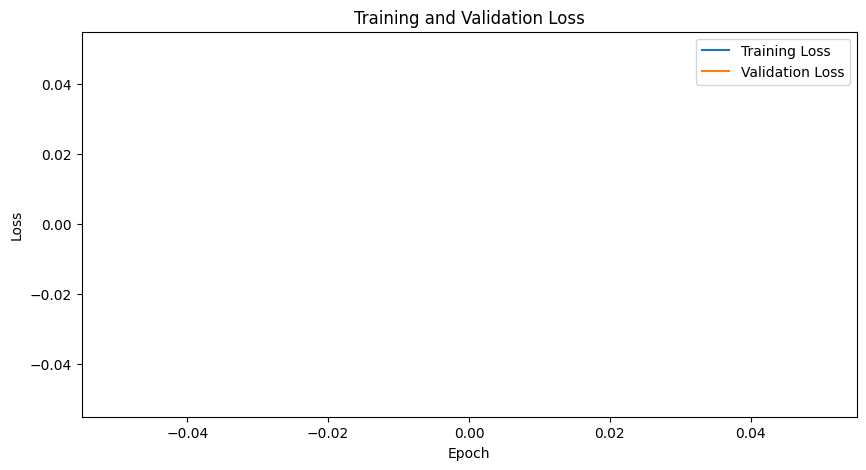

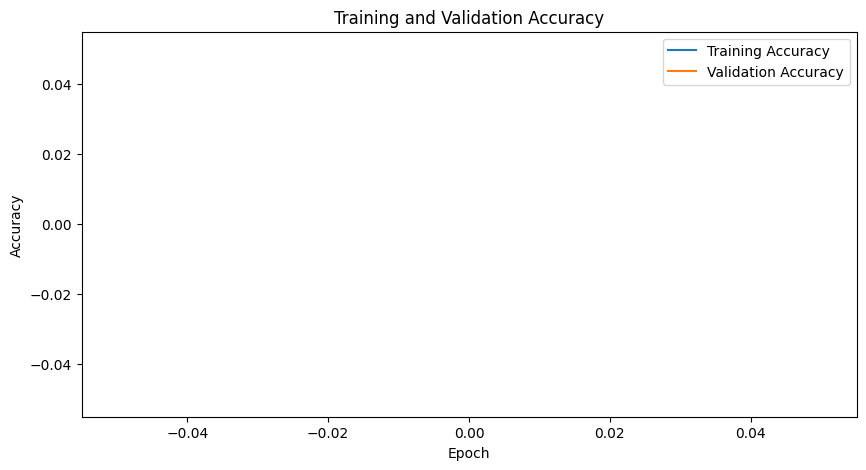

In [40]:
import pandas as pd
import matplotlib.pyplot as plt



def parse_log(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    epochs = []
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for line in lines:
        if "Epoch" in line:
            epochs.append(int(line.split('/')[0].split(' ')[1]))
        if "- loss:" in line:
            split_line = line.split('-')
            training_loss.append(float(split_line[1].split(':')[1]))
            training_accuracy.append(float(split_line[2].split(':')[1]))
            validation_loss.append(float(split_line[3].split(':')[1]))
            validation_accuracy.append(float(split_line[4].split(':')[1]))

    return epochs, training_loss, training_accuracy, validation_loss, validation_accuracy


file_path = 'training_log.txt'
epochs, training_loss, training_accuracy, validation_loss, validation_accuracy = parse_log(file_path)


df = pd.DataFrame({
    "Epoch": epochs,
    "Training Loss": training_loss,
    "Training Accuracy": training_accuracy,
    "Validation Loss": validation_loss,
    "Validation Accuracy": validation_accuracy
}).set_index("Epoch")


plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Training Loss"], label='Training Loss')
plt.plot(df.index, df["Validation Loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Training Accuracy"], label='Training Accuracy')
plt.plot(df.index, df["Validation Accuracy"], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
